# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://docs.langchain.com/oss/python/concepts/memory#profile) or [collection](https://docs.langchain.com/oss/python/concepts/memory#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to pull together the pieces we've learned to build an agent with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

The chatbots we built previously *always* reflected on the conversation and saved memories. 

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection. 

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items. 

In [1]:
import uuid
from pprint import pprint
from helper import *
from pydantic import BaseModel, Field
from trustcall import create_extractor
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, merge_message_runs
from typing import TypedDict, Literal, Optional, List
from IPython.display import Image, display
from datetime import datetime
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.

What if we want visibility into the *specific changes* made by Trustcall?

For example, we saw before that Trustcall has some of its own tools to:

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

Below, we'll show how to do this!

In [2]:
class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )

class MemoryCollection(BaseModel):
    memories: List[Memory] = Field(
        description="A list of memories about the user."
    )

When storing objects (e.g., memories) in the [Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

In [3]:
# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

In [4]:
spy = Spy()

In [5]:
# Initialize the model
model = ChatOpenAI(temperature=0, model_name="gpt-4o")
model.invoke("Hello").content

'Hello! How can I assist you today?'

In [6]:
trust_call_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True
)

# Add the spy as a listener
trust_call_extractor_with_listner = trust_call_extractor.with_listeners(on_end=spy)

In [7]:
# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Umer."), 
    AIMessage(content="Nice to meet you, Umer."), 
    HumanMessage(content="This morning I had a nice bike ride in San Francisco.")
]

# Invoke the extractor
result = trust_call_extractor.invoke({
    "messages": [SystemMessage(content=instruction)] + conversation
})

In [8]:
# Messages contain the tool calls
for m in result['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_OxEYqtiNZ3IaTFrvCuzhD07e)
 Call ID: call_OxEYqtiNZ3IaTFrvCuzhD07e
  Args:
    content: Umer had a nice bike ride in San Francisco this morning.


In [9]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Umer had a nice bike ride in San Francisco this morning.'


In [10]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_OxEYqtiNZ3IaTFrvCuzhD07e'}


In [11]:
# Update the conversation
updated_conversation = [
    AIMessage(content="That's great, did you do after?"), 
    HumanMessage(content="I went to Tartine and ate a croissant."),                        
    AIMessage(content="What else is on your mind?"),
    HumanMessage(content="I was thinking about my Japan, and going back this winter!")
]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

In [12]:
# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_mem = [(str(i), tool_name, m) for i, m in enumerate(result['responses'])] if result['responses'] else []
existing_mem

[('0',
  'Memory',
  Memory(content='Umer had a nice bike ride in San Francisco this morning.'))]

In [13]:
# Invoke the extractor with our updated conversation and existing memories
result = trust_call_extractor_with_listner.invoke({
    "messages": updated_conversation,
    "existing": existing_mem
})

In [14]:
result.keys()

dict_keys(['messages', 'responses', 'response_metadata', 'attempts'])

In [15]:
for m in result['response_metadata']:
    print(m)

{'id': 'call_BB1bcDf1B0FoCWeQcYNHozHR', 'json_doc_id': '0'}
{'id': 'call_LqW38eZQZk59rw8Otfx30smt'}
{'id': 'call_sIUz66bOYUfxmsjRJ2kSIzpf'}


In [16]:
# Messages contain the tool calls
for m in result['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_BB1bcDf1B0FoCWeQcYNHozHR)
 Call ID: call_BB1bcDf1B0FoCWeQcYNHozHR
  Args:
    content: Umer had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.
  Memory (call_LqW38eZQZk59rw8Otfx30smt)
 Call ID: call_LqW38eZQZk59rw8Otfx30smt
  Args:
    content: Umer went to Tartine and ate a croissant.
  Memory (call_sIUz66bOYUfxmsjRJ2kSIzpf)
 Call ID: call_sIUz66bOYUfxmsjRJ2kSIzpf
  Args:
    content: Umer was thinking about Japan and going back this winter.


In [17]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='Umer had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.'
content='Umer went to Tartine and ate a croissant.'
content='Umer was thinking about Japan and going back this winter.'


In [18]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': '1. Add the new memory about going to Tartine and eating a croissant to the existing memory content. 2. Add the new memory about thinking about Japan and going back this winter to the existing memory content.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Umer had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.'}]},
   'id': 'call_BB1bcDf1B0FoCWeQcYNHozHR',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Umer went to Tartine and ate a croissant.'},
   'id': 'call_LqW38eZQZk59rw8Otfx30smt',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Umer was thinking about Japan and going back this winter.'},
   'id': 'call_sIUz66bOYUfxmsjRJ2kSIzpf',
   'type': 'tool_call'}]]

In [19]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

In [20]:
# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: 1. Add the new memory about going to Tartine and eating a croissant to the existing memory content. 2. Add the new memory about thinking about Japan and going back this winter to the existing memory content.
Added content: Umer had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.

New Memory created:
Content: {'content': 'Umer went to Tartine and ate a croissant.'}

New Memory created:
Content: {'content': 'Umer was thinking about Japan and going back this winter.'}


## Creating an agent

There are many different agent architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://docs.langchain.com/oss/python/langgraph/workflows-agents#agents) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [21]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [22]:
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

In [23]:
# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    
    name: Optional[str] = Field(
        description="The name of the user", default=None
    )
    location: Optional[str] = Field(
        description="The user's location", default=None
    )
    job: Optional[str] = Field(
        description="The user's job", default=None
    )
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers", default=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", default_factory=list
    )

In [24]:
# ToDo schema
class ToDo(BaseModel):
    """This is the to do list of the user"""
    
    tasks: List[str] = Field(
        description="The tasks that the user has to do", default=list
    )
    time_to_complete: Optional[int] = Field(
        description="Estimated time to complete the tasks (minutes)", default=None
    )
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)", default=None
    )
    solutions: List[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_length=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

In [25]:
# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    llm=model,
    tools=[Profile],
    tool_choice="Profile"
)

c:\Gen-Agentic-AI-Tutorials\.venv\Lib\site-packages\pydantic\json_schema.py:2448: PydanticJsonSchemaWarning: Default value <class 'list'> is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


### **Node definition**

In [26]:
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([
        SystemMessage(content=system_msg)]+state["messages"
    ])

    return {"messages": [response]}

In [27]:
def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = (
        [
            (existing_item.key, tool_name, existing_item.value)
            for existing_item in existing_items
        ] if existing_items else None)

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({
        "messages": updated_messages, 
        "existing": existing_memories
    })

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

In [28]:
def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
        model,
        tools=[ToDo],
        tool_choice=tool_name,
        enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

In [29]:
def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke(
        [SystemMessage(content=system_msg)]+state['messages'][:-1] + 
        [HumanMessage(content="Please update the instructions based on the conversation")]
    )

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

In [30]:
# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

In [31]:
# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("task_mAIstro", task_mAIstro)
builder.add_node("update_profile", update_profile)
builder.add_node("update_todos", update_todos)
builder.add_node("update_instructions", update_instructions)

# Add edges
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")

# Store for long-term (across-thread) memory
accross_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Create the graph
graph = builder.compile(checkpointer=within_thread_memory, store=accross_thread_memory)

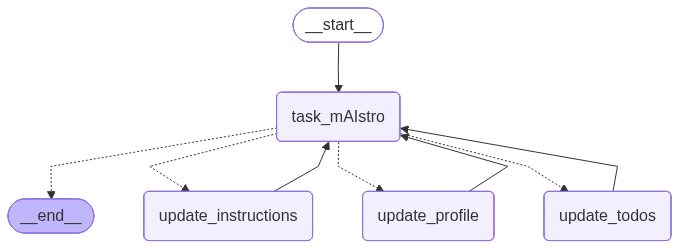

In [32]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### **Test**

In [33]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Umer"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Umer. I live in Karachi with my Family. I am single.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Umer. I live in Karachi with my Family. I am single.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_zRNxPN0ABWIlIwmfGEh5H9a8)
 Call ID: call_zRNxPN0ABWIlIwmfGEh5H9a8
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! How can I assist you today?


In [34]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_W2OKd5MttUygrubkNG2lAQJ8)
 Call ID: call_W2OKd5MttUygrubkNG2lAQJ8
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'tasks': ['Book swim lessons for the baby'], 'solutions': ['Research local swim schools', 'Check availability and pricing', 'Book a trial lesson'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Book swim lessons for the baby" to your ToDo list. If you need any help with this task, feel free to ask!


In [35]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_lCYHr55reHeuJdlQaTHJs1m0)
 Call ID: call_lCYHr55reHeuJdlQaTHJs1m0
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include specific local businesses or vendors when creating or updating your ToDo items. If there's anything else you need, just let me know!


In [36]:
# Check for updated instructions
user_id = "Umer"

# Search 
for memory in accross_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': "<current_instructions>\nWhen creating or updating ToDo list items, include specific local businesses or vendors relevant to the task. For example, if booking swim lessons, research and suggest local swim schools in the user's area.\n</current_instructions>"}


In [37]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_tZFqSkva5WEoneWxs3RCqnV4)
 Call ID: call_tZFqSkva5WEoneWxs3RCqnV4
  Args:
    update_type: todo


c:\Gen-Agentic-AI-Tutorials\.venv\Lib\site-packages\pydantic\json_schema.py:2448: PydanticJsonSchemaWarning: Default value <class 'list'> is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


================================= Tool Message =================================

New ToDo created:
Content: {'tasks': ['Fix the jammed electric Yale lock on the door'], 'solutions': ['Contact a local locksmith', 'Check the warranty and contact Yale support', 'Look for troubleshooting guides online'], 'status': 'not started'}

Document 4544b02c-c385-4dfa-9943-3a22d6ec1a94 updated:
Plan: Add specific local locksmiths to the solutions for fixing the jammed electric Yale lock.
Added content: ['Contact a local locksmith', 'Check the warranty and contact Yale support', 'Look for troubleshooting guides online']
================================== Ai Message ==================================

I've added "Fix the jammed electric Yale lock on the door" to your ToDo list. If you need recommendations for local locksmiths or any other assistance, just let me know!


In [39]:
# Namespace for the memory to save
user_id = "Umer"

# Search 
for memory in accross_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'tasks': ['Book swim lessons for the baby'], 'time_to_complete': None, 'deadline': None, 'solutions': ['Research local swim schools', 'Check availability and pricing', 'Book a trial lesson', 'Contact a local locksmith', 'Check the warranty and contact Yale support', 'Look for troubleshooting guides online'], 'status': 'not started'}
{'tasks': ['Fix the jammed electric Yale lock on the door'], 'time_to_complete': None, 'deadline': None, 'solutions': ['Contact a local locksmith', 'Check the warranty and contact Yale support', 'Look for troubleshooting guides online'], 'status': 'not started'}


In [40]:

# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_BE6fD0pECtgvgzUXYcFHTpY2)
 Call ID: call_BE6fD0pECtgvgzUXYcFHTpY2
  Args:
    update_type: todo


c:\Gen-Agentic-AI-Tutorials\.venv\Lib\site-packages\pydantic\json_schema.py:2448: PydanticJsonSchemaWarning: Default value <class 'list'> is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


================================= Tool Message =================================

Document 4544b02c-c385-4dfa-9943-3a22d6ec1a94 updated:
Plan: Add a deadline for the task 'Book swim lessons for the baby' to be completed by the end of November.
Added content: 2026-11-30T23:59:59
================================== Ai Message ==================================

I've updated the deadline for booking swim lessons for the baby to the end of November. If there's anything else you need, feel free to ask!


In [41]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_3BMOxFg5Z2C2WVCrI2BFUzYN)
 Call ID: call_3BMOxFg5Z2C2WVCrI2BFUzYN
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'tasks': ['Call back City Toyota to schedule car service'], 'solutions': ['Find the contact number for City Toyota', 'Check available service slots', 'Prepare any questions or concerns about the car'], 'status': 'not started'}

Document 8ce527bd-6d7a-4409-a01c-49739f4722bc updated:
Plan: Add 'City Toyota' as a specific local business to the solutions for scheduling car service.
Added content: City Toyota
================================== Ai Message ==================================

I've added "Call back City Toyota to schedule car ser

In [43]:
# Namespace for the memory to save
user_id = "Umer"

# Search 
for memory in accross_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'tasks': ['Book swim lessons for the baby'], 'time_to_complete': None, 'deadline': '2026-11-30T23:59:59', 'solutions': ['Research local swim schools', 'Check availability and pricing', 'Book a trial lesson', 'Contact a local locksmith', 'Check the warranty and contact Yale support', 'Look for troubleshooting guides online'], 'status': 'not started'}
{'tasks': ['Fix the jammed electric Yale lock on the door'], 'time_to_complete': None, 'deadline': None, 'solutions': ['Contact a local locksmith', 'Check the warranty and contact Yale support', 'Look for troubleshooting guides online', 'City Toyota'], 'status': 'not started'}
{'tasks': ['Call back City Toyota to schedule car service'], 'time_to_complete': None, 'deadline': None, 'solutions': ['Find the contact number for City Toyota', 'Check available service slots', 'Prepare any questions or concerns about the car'], 'status': 'not started'}


In [44]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Umer"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

Let's take a look at your current tasks:

1. **Book swim lessons for the baby** - This might take more than 30 minutes as it involves researching local swim schools, checking availability and pricing, and booking a trial lesson.

2. **Fix the jammed electric Yale lock on the door** - This task might also take longer than 30 minutes, especially if it involves contacting a locksmith or troubleshooting.

3. **Call back City Toyota to schedule car service** - This task could potentially be completed within 30 minutes. You can find the contact number for City Toyota, check available service slots, and prepare any questions or concerns about the car.

I recommend focusing on calling City Toyota to schedule your car service, as it seems the most feasible within your time frame.


In [45]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

To find local swim schools in Karachi, you might consider the following options:

1. **Karachi American School** - They often have swimming facilities and may offer lessons to the public.
2. **Karachi Gymkhana** - Known for its sports facilities, they might offer swimming lessons.
3. **Defence Authority Club** - They have a swimming pool and may provide lessons.
4. **The City School Sports Complex** - They might offer swimming lessons for children.
5. **Local Community Centers** - Check if any nearby community centers offer swim lessons.

You can start by calling these places to inquire about their swim lesson programs, availability, and pricing. Let me know if you want to add this to your ToDo list!
